# ONLY RUN THIS ONCE TO SET WORKING DIR - otherwise restart notebook and run whole code again to set path correctly.
import os
# Set working dir to \\Bluecrest
os.chdir(os.path.dirname(os.getcwd()))

print(os.getcwd())

In [2]:
import pandas as pd
import numpy as np
import data_manager as dm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SequentialFeatureSelector
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

##### User inputs below - please enter below

In [3]:
index = 'Nasdaq 100' # Either 'Nasdaq 100' or 'S&P 500'
start_date = '2020-01-01'
end_date = '2024-01-01'

# User selected symbols
securities = ['ADBE', 'AMD', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'AEP', 'AMGN', 'ADI', 'ANSS']

In [4]:
# Full index symbols - Used for automatically selecting top best 10 stocks that explain the index's return variance
full_symbols = dm.get_symbols(index)

In [5]:
# Get index data
index_df = dm.get_index_data(index, start_date, end_date)
index_df['index_ret'] = np.log(index_df.adj_close/index_df.adj_close.shift(1))
index_df.dropna(inplace=True)

# Get user provided securities data
stock_df = []
for i in securities:
    tmp = dm.get_sym_dates_index(index, i, start_date, end_date)
    tmp['ret'] = np.log(tmp.adj_close/tmp.adj_close.shift(1))
    if tmp.isna().sum().sum() > 1:
        print(f"Skipping due to missing data: {i}")
        continue
    tmp.dropna(inplace=True)
    stock_df.append(tmp)
stock_df = pd.concat(stock_df)

In [6]:
index_df['symbol'] = index
stock_df = stock_df.pivot(index='date', columns='symbol', values='ret')
index_df = index_df.pivot(index='date', columns='symbol', values='index_ret')

# Create our dataframe with the securities + index returns
df = pd.merge(index_df, stock_df, left_index=True, right_index=True)
df.dropna(inplace=True)

In [7]:
cols = [i for i in df.columns if index not in i]

Security weights...
('ADBE', 7.8265006064969445)
('ADI', 13.397014932218415)
('AEP', 5.164712406626997)
('AMD', 6.5708336068672075)
('AMGN', 5.957603424497796)
('AMZN', 12.569390628155947)
('ANSS', 7.564059761266266)
('GOOG', 12.785838065944407)
('GOOGL', 0.011524351491135065)
('MSFT', 21.740486802084558)

R_squared: 0.949383635185383


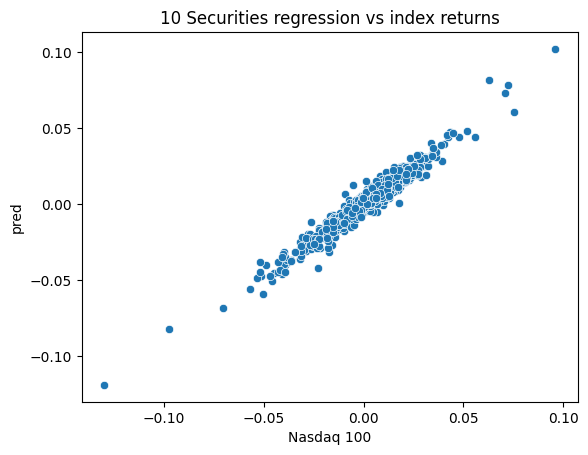

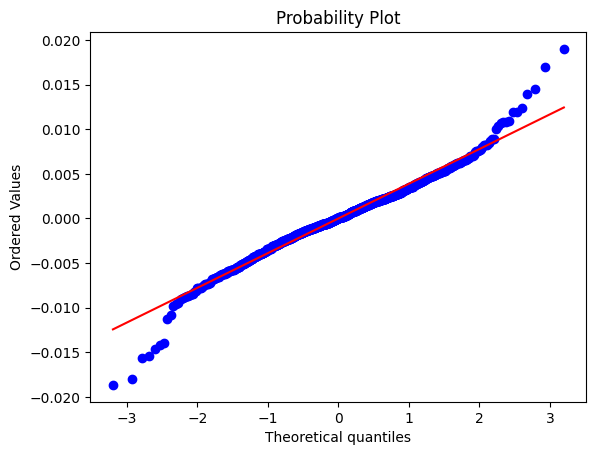

In [8]:
# Generate Linear regression model.  Y = Index returns, X = securities return
rgr = LinearRegression()
rgr.fit(df[cols], df[index])

# Calculate the index prediction
df['pred'] = rgr.predict(df[cols])
# Find the error term
df['error'] = df[index] - df.pred

# Get the coef (security weighting)
security_weights = list(zip(cols, rgr.coef_*100))

print(f"Security weights...")
for i in security_weights:
    print(i)

# R_squared used as the variance captured of the index's returns
print(f"\nR_squared: {r2_score(df[index], df.pred)}")


plt.figure()
plt.title('10 Securities regression vs index returns')
sns.scatterplot(df, x=index, y='pred')
plt.show()

plt.figure('Q-Q plot of residual')
stats.probplot(df.error, dist="norm", plot=plt)
plt.show()

##### Find top 10 best securities which describe the index's return most accurately

In [9]:
# Get security data - For all the symbols within the index.  We had some issues with some adj_close being NaNs, so these stocks are dropped for now.
# Below forms our components dataframe.
all_stock_df = []
for i in full_symbols:
    try:
        tmp = dm.get_sym_dates_index(index, i, start_date, end_date)
        tmp['ret'] = np.log(tmp.adj_close/tmp.adj_close.shift(1))
        if tmp.isna().sum().sum() > 1:
            print(f"Skipping due to missing data: {i}")
            continue
        tmp.dropna(inplace=True)
        all_stock_df.append(tmp)
    except Exception as e:
        continue
all_stock_df = pd.concat(all_stock_df)

Skipping due to missing data: ABNB
Skipping due to missing data: ARM
Skipping due to missing data: CEG
Skipping due to missing data: DASH
Skipping due to missing data: GEHC
Skipping due to missing data: GFS


In [10]:
# Create a dataframe with index and components returns
all_stock_df = all_stock_df.pivot(index='date', columns='symbol', values='ret')
df_stocks_index = pd.merge(index_df, all_stock_df, left_index=True, right_index=True)
df_stocks_index.dropna(inplace=True)

In [11]:
cols = [i for i in df_stocks_index.columns if index not in i]

In [12]:
# Model using linear regression.
# We use Sequential feature selection (backward) to extract the top 10 stocks which describe most of the index's returns.
model = LinearRegression()
sfs = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward')
sfs.fit(df_stocks_index[cols], df_stocks_index[index])

In [ ]:
# Get top 10 selected stocks
selected_stocks = df_stocks_index[cols].columns[sfs.get_support()]

# Linear model using top 10 selected stocks
best_stocks_model = LinearRegression()
best_stocks_model.fit(df_stocks_index[selected_stocks], df_stocks_index[index])

# Calculate pred
df_stocks_index['pred'] = best_stocks_model.predict(df_stocks_index[selected_stocks])

# Calculate error terms (to see if they are normally distributed)
df_stocks_index['error'] = df_stocks_index[index] - df_stocks_index.pred

# Calculate captured variance as the R-Squared
print(f"R_Squared: {r2_score(df_stocks_index[index], df_stocks_index['pred'])}")

In [ ]:
plt.figure()
plt.title('Top 10 Securities regression vs index returns')
sns.scatterplot(df_stocks_index, x=index, y='pred')
plt.show()

plt.figure('Q-Q plot of residual')
stats.probplot(df_stocks_index.error, dist="norm", plot=plt)
plt.show()

# From the error terms, it seems to look like its struggling at the extereme values.
# This could be rectified by clipping the returns to minimize the impact from outliers